# Demo code for Ito et al., 2017.
### Network-to-network information transfer mapping. Replicates figures from supplementary figure 1

#### Author: Takuya Ito (takuya.ito@rutgers.edu)

#### Ito T, Kulkarni KR, Schultz DH, Mill RD, Chen RH, Solomyak LI, Cole MW (2017). Cognitive task information is transferred between brain regions via resting-state network topology. bioRxiv. https://doi.org/10.1101/101782

####  Last updated: 04/24/2017
**Summary:** 

Reads in preprocessed, empirical data. For each subject, we provide miniblock activation estimates (obtained from a beta series regression for every region in the Glasser et al. (2016) atlas), and a whole-brain FC matrix estimated using multiple linear regression. We also provide task-rule condition labels for each miniblock (e.g., miniblock 1 is associated with the logic rule "both").

For each subject, we perform network-to-network information transfer mapping as described in the manuscript.
We then compute group statistics to obtain the panels for Supplementary Figure 1. Key components of information transfer mapping (i.e., activity flow mapping + predicted-to-actual similarity) are found in the informationtransfermapping.py module in the base directory.

See Supplemental materials/methods for a full description.

In [2]:
import sys
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.sandbox.stats.multicomp as mc
import multiprocessing as mp
%matplotlib inline
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import warnings
warnings.filterwarnings('ignore')

import networkinformationtransfer as n2n


from matplotlib.colors import Normalize


class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# 0.0 Basic parameters

In [3]:
# Set basic parameters
datadir = './data/'
runLength = 4648
subjNums = ['032', '033', '037', '038', '039', '045', 
            '013', '014', '016', '017', '018', '021', 
            '023', '024', '025', '026', '027', '031', 
            '035', '046', '042', '028', '048', '053', 
            '040', '049', '057', '062', '050', '030', '047', '034']

# Load in network array
networkdef = np.loadtxt(datadir + 'network_array.csv', delimiter=',')


# Load in network keys (each network associated with a number in network array)
networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud1':8, 'aud2':9, 'dan':11}
# Force aud2 key to be the same as aud1 (merging two auditory networks)
aud2_ind = np.where(networkdef==networkmappings['aud2'])[0]
networkdef[aud2_ind] = networkmappings['aud1']
# Redefine new network mappings with no aud1/aud2 distinction
networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud':8, 'dan':11}

# 1.0 Run information transfer mapping procedure

## 1.1 First load in resting-state FC matrices for subjects

In [4]:
fcmat = {}
for subj in subjNums:
    fcmat[subj] = np.loadtxt('data/FC_Estimates/' + subj + '_multregconn_restfc.csv', delimiter=',')

## 1.2 Perform network-to-network information transfer mapping procedure using python module

### 1.2.1 First construct a wrapper to pass through a multiprocessing scheme

In [5]:
def informationTransferMappingWrapper((subj,fcmat)):
    """
    A wrapper so we can use multiprocessing to run subjects in parallel
    """
    out = n2n.networkToNetworkInformationTransferMapping(subj,fcmat,null=False)
    return out 

### 1.2.2 Run using multiprocessing (parallel processing) to speed-up computation

In [6]:
inputs = []
for subj in subjNums:
    inputs.append((subj,fcmat[subj]))
    
pool = mp.Pool(processes=32)
results = pool.map_async(informationTransferMappingWrapper,inputs).get()
pool.close()
pool.join()

# Collect results
ruledims = ['logic','sensory','motor']
ite_matrix = {}
for ruledim in ruledims:
    ite_matrix[ruledim] = np.zeros((len(networkmappings),len(networkmappings),len(subjNums)))

scount = 0
for result in results:
    for ruledim in ruledims:
        ite_matrix[ruledim][:,:,scount] = result[ruledim]
        
    scount += 1

# 2.0 Compute group statistics

##### Keep track of networks to matrix indices

In [7]:
# Create dictionary that reflects network ordering for matrix rows and columns
netkeys = {0:'vis',1:'smn',2:'con',3:'dmn',4:'fpn', 5:'aud', 6:'dan'}
num_networks=len(netkeys)

In [8]:
baseline = 0.0
avg_rho = {}
tstats = {}
pvals = {}
for ruledim in ruledims:
    avg_rho[ruledim] = np.zeros((num_networks,num_networks))
    tstats[ruledim] = np.zeros((num_networks,num_networks))
    pvals[ruledim] = np.zeros((num_networks,num_networks))
    
    for net1 in netkeys:
        
        for net2 in netkeys:
            # Skip if net1 and net2
            if net1==net2: 
                avg_rho[ruledim][net1,net2] = np.nan
                tstats[ruledim][net1,net2] = np.nan
                pvals[ruledim][net1,net2] = np.nan
                continue
                
            # Store results
            avg_rho[ruledim][net1,net2] = np.mean(ite_matrix[ruledim][net1,net2,:])
            t, p = stats.ttest_1samp(ite_matrix[ruledim][net1,net2,:],0)
            # One-sided t-test
            tstats[ruledim][net1,net2] = t
            if t>0:
                p=p/2.0
            else:
                p = 1-p/2.0
            pvals[ruledim][net1,net2] = p
            
                

## 2.1 Perform multiple comparisons (using false discovery rate)

In [9]:
# Compute group stats
baseline = 0.0
triu_indices = np.triu_indices(len(networkmappings),k=1)
tril_indices = np.tril_indices(len(networkmappings),k=-1)

qmat = {}
for ruledim in ruledims:

    
    qmat[ruledim] = np.zeros((num_networks,num_networks))
    
    tmpq = []
    tmpq.extend(pvals[ruledim][triu_indices])
    tmpq.extend(pvals[ruledim][tril_indices])
    tmpq = mc.fdrcorrection0(tmpq)[1]
    qmat[ruledim][triu_indices] = tmpq[0:len(triu_indices[0])]
    qmat[ruledim][tril_indices] = tmpq[len(triu_indices[0]):]



## 2.2 Plot results

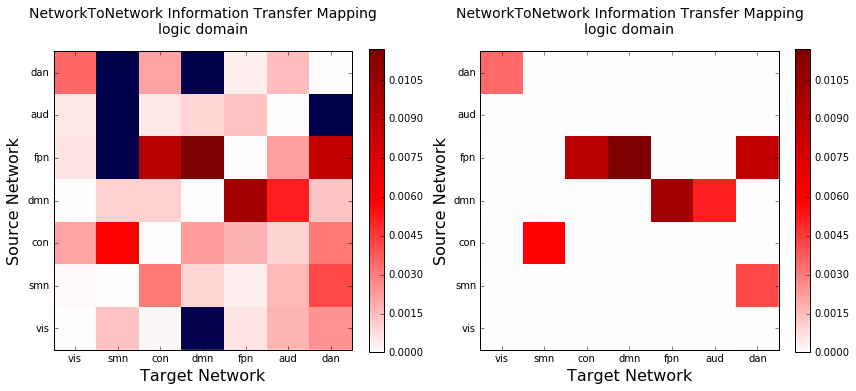

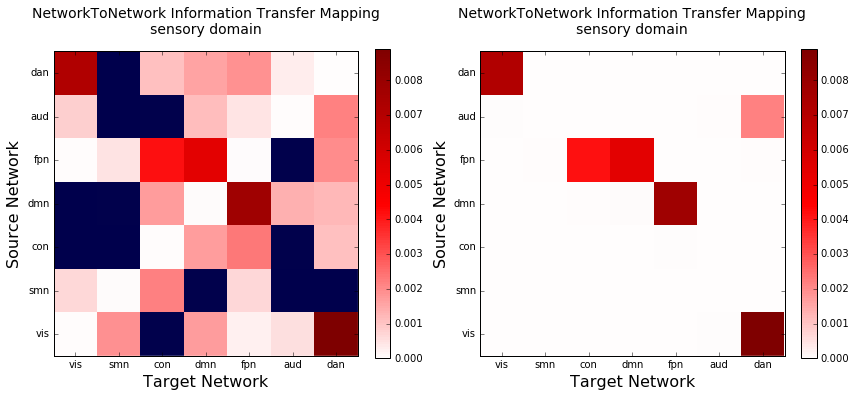

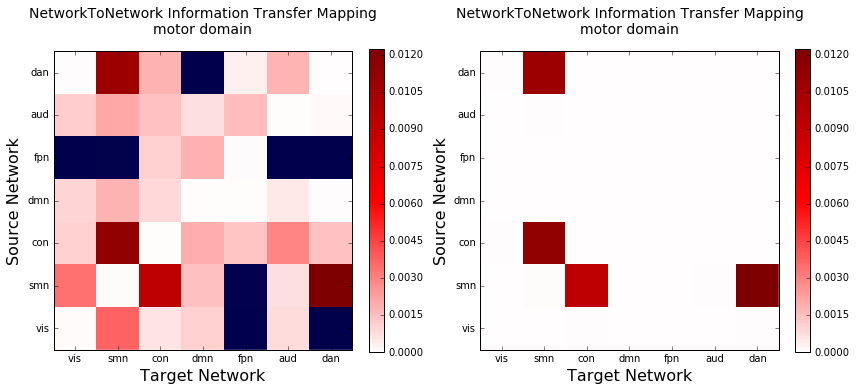

In [10]:
for ruledim in ruledims:
    plt.figure(figsize=(12,10))
    # First visualize unthresholded results
    plt.subplot(121)
    plt.title('NetworkToNetwork Information Transfer Mapping\n' + ruledim + ' domain', fontsize=14, y=1.04)
    mat = avg_rho[ruledim]
    np.fill_diagonal(mat,0)
    norm = MidpointNormalize(midpoint=0)
    plt.imshow(mat, origin='lower',norm=norm, vmin=0, cmap='seismic', interpolation='none')
    plt.xticks(netkeys.keys(),netkeys.values())
    plt.yticks(netkeys.keys(),netkeys.values())
    plt.ylabel('Source Network',fontsize=16)
    plt.xlabel('Target Network',fontsize=16)
    plt.colorbar(fraction=.046)
    
    # Next visualize thresholded results (after multiple comparisons)
    plt.subplot(122)
    plt.title('NetworkToNetwork Information Transfer Mapping\n' + ruledim + ' domain' , fontsize=14, y=1.04)
    mat = avg_rho[ruledim]
    thresh = qmat[ruledim] < 0.05
    # Threshold using q < 0.05
    mat = np.multiply(mat,thresh)
    np.fill_diagonal(mat,0)
    norm = MidpointNormalize(midpoint=0)
    plt.imshow(mat, origin='lower',norm=norm, vmin=0, cmap='seismic', interpolation='none')
    plt.xticks(netkeys.keys(),netkeys.values())
    plt.yticks(netkeys.keys(),netkeys.values())
    plt.ylabel('Source Network',fontsize=16)
    plt.xlabel('Target Network',fontsize=16)
    plt.colorbar(fraction=.046)
    plt.tight_layout()
